# Milk Quality Analysis and Machine Learning Pipeline

This notebook demonstrates the complete pipeline for milk quality analysis, including data generation with realistic variations, exploratory data analysis, model training and evaluation with multiple algorithms.

In [17]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import os

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')


## 1. Data Generation with Realistic Variations

Generate synthetic milk quality data with sufficient randomness to ensure realistic model performance.

In [18]:

def generate_training_data(n_samples=50000):
    '''Generate synthetic training data with realistic variations'''
    np.random.seed(42)
    
    ph_values = np.random.uniform(5.5, 7.5, n_samples)  # Expanded pH range
    turbidity = np.random.uniform(0.5, 30.0, n_samples)  # Expanded turbidity range
    ec_values = np.random.uniform(3.5, 7.0, n_samples)   # Expanded EC range
    protein_content = np.random.uniform(1.5, 4.0, n_samples)  # Expanded protein range
    
    scc_distribution = np.random.choice(['low', 'medium', 'high', 'very_high', 'extreme'], 
                                      size=n_samples, 
                                      p=[0.4, 0.3, 0.15, 0.1, 0.05])  # Adjusted probabilities
    
    scc_values = np.zeros(n_samples)
    for i, dist in enumerate(scc_distribution):
        if dist == 'low':
            scc_values[i] = np.random.uniform(10000, 200000)
        elif dist == 'medium':
            scc_values[i] = np.random.uniform(200001, 400000)
        elif dist == 'high':
            scc_values[i] = np.random.uniform(400001, 1200000)
        elif dist == 'very_high':
            scc_values[i] = np.random.uniform(1200001, 5000000)
        else:  # extreme
            scc_values[i] = np.random.uniform(5000001, 10000000)
    
    action_mapping = {
        'Negative': 'Safe to use',
        'Trace': 'Monitor',
        'Weak_Positive': 'Check the cow',
        'Distinct_Positive': 'Veterinary care',
        'Definite_Positive': 'Reject the milk'
    }
    
    quality_categories = []
    actions = []
    
    for i in range(n_samples):
        scc = scc_values[i]
        ph = ph_values[i]
        turb = turbidity[i]
        ec = ec_values[i]
        
        if np.random.random() < 0.2:
            label = np.random.choice(['Negative', 'Trace', 'Weak_Positive', 'Distinct_Positive', 'Definite_Positive'])
        else:
            if scc <= 200_000:
                if (ph < 6.0 or ph > 7.0 or turb > 5.0 or ec > 5.5) and np.random.random() < 0.3:
                    label = 'Trace'
                else:
                    label = 'Negative'
            elif scc <= 400_000:
                rand = np.random.random()
                if rand < 0.3:
                    label = 'Negative'
                elif rand < 0.6:
                    label = 'Weak_Positive'
                else:
                    label = 'Trace'
            elif scc <= 1_200_000:
                rand = np.random.random()
                if rand < 0.3:
                    label = 'Trace'
                elif rand < 0.6:
                    label = 'Distinct_Positive'
                else:
                    label = 'Weak_Positive'
            elif scc <= 5_000_000:
                rand = np.random.random()
                if rand < 0.3:
                    label = 'Weak_Positive'
                elif rand < 0.6:
                    label = 'Definite_Positive'
                else:
                    label = 'Distinct_Positive'
            else:
                if np.random.random() < 0.3:
                    label = 'Distinct_Positive'
                else:
                    label = 'Definite_Positive'
        
        quality_categories.append(label)
        actions.append(action_mapping[label])
    
    df = pd.DataFrame({
        'pH': ph_values,
        'Turbidity': turbidity,
        'EC': ec_values,
        'Protein': protein_content,
        'SCC': scc_values,
        'MilkQuality': quality_categories,
        'Action': actions
    })
    
    os.makedirs('data', exist_ok=True)
    df.to_csv('data/milk_quality_training_data.csv', index=False)
    print(f"Generated {n_samples} samples and saved to data/milk_quality_training_data.csv")
    
    return df


In [19]:
# Generate the data
df = generate_training_data()
df.head()

Generated 50000 samples and saved to data/milk_quality_training_data.csv


,pH,Turbidity,EC,Protein,SCC,MilkQuality,Action
0,6.249080,25.493479,5.532727,1.673029,188159.815882,Weak_Positive,Check the cow
1,7.401429,15.088253,5.344401,2.964242,214656.508895,Negative,Safe to use
2,6.963988,6.266236,4.728629,3.497172,45412.312548,Negative,Safe to use
3,6.697317,22.230933,5.226244,3.411183,329894.574371,Trace,Monitor
4,5.812037,12.851005,4.777838,3.593491,92595.074581,Negative,Safe to use


## 2. Exploratory Data Analysis

Analyze the distribution of milk quality categories and relationships between features.

In [20]:
# Display quality distribution
quality_counts = df['MilkQuality'].value_counts()
print("Milk Quality Distribution:")
print(quality_counts)
print("\nPercentage Distribution:")
print(quality_counts / len(df) * 100)

Milk Quality Distribution:
MilkQuality
Negative             16977
Trace                13236
Weak_Positive         9120
Distinct_Positive     6018
Definite_Positive     4649
Name: count, dtype: int64

Percentage Distribution:
MilkQuality
Negative             33.954
Trace                26.472
Weak_Positive        18.240
Distinct_Positive    12.036
Definite_Positive     9.298
Name: count, dtype: float64


/var/folders/7r/bclj42dj1v7bjzt9nsm3m4yw0000gn/T/ipykernel_57580/3797299469.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='MilkQuality', order=df['MilkQuality'].value_counts().index, palette='viridis')


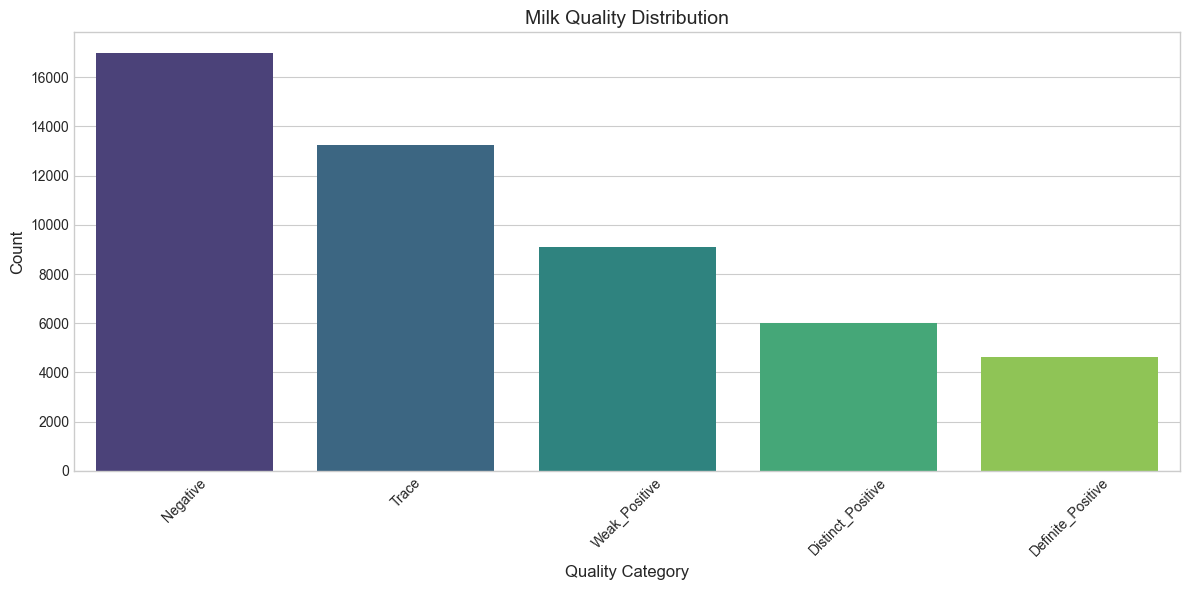

In [21]:
# Plot quality distribution
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='MilkQuality', order=df['MilkQuality'].value_counts().index, palette='viridis')
plt.title('Milk Quality Distribution', fontsize=14)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Quality Category', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

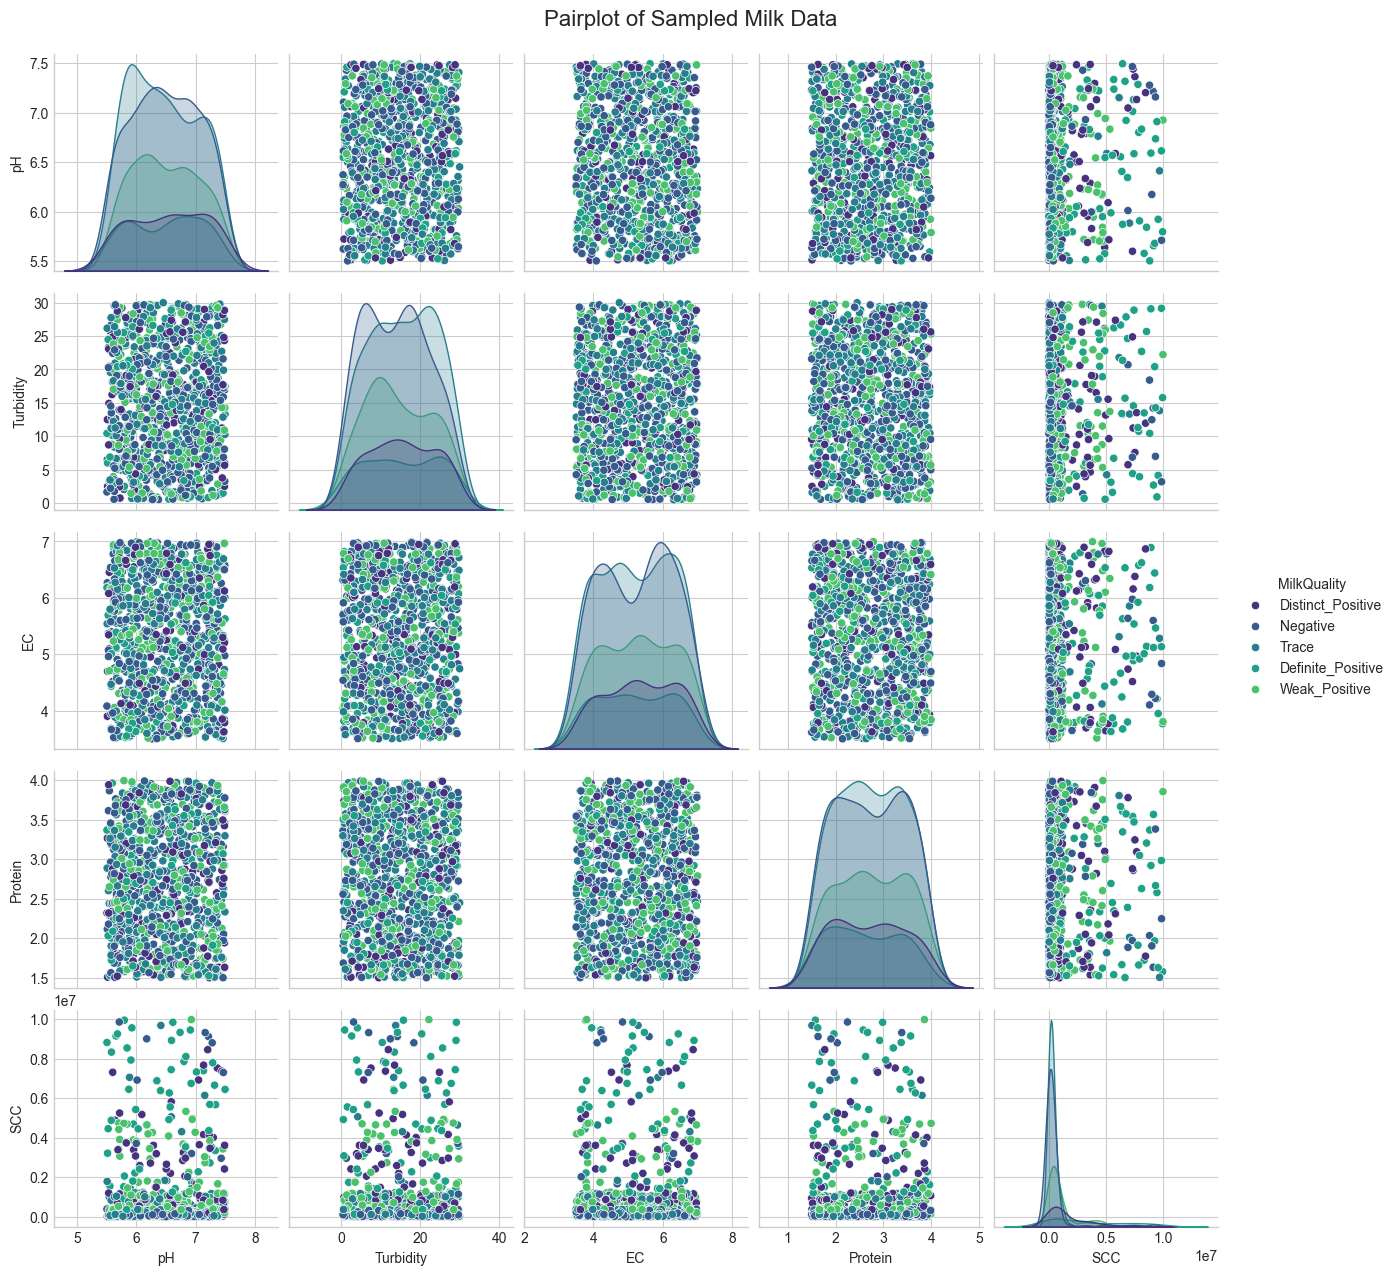

In [22]:
# Sample data for visualization (using a smaller subset for better visualization)
df_sample = df.sample(1000, random_state=42)

sns.pairplot(df_sample, hue='MilkQuality', vars=['pH', 'Turbidity', 'EC', 'Protein', 'SCC'])
plt.suptitle('Pairplot of Sampled Milk Data', y=1.02, fontsize=16)
plt.show()

/var/folders/7r/bclj42dj1v7bjzt9nsm3m4yw0000gn/T/ipykernel_57580/1882695279.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/var/folders/7r/bclj42dj1v7bjzt9nsm3m4yw0000gn/T/ipykernel_57580/1882695279.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/var/folders/7r/bclj42dj1v7bjzt9nsm3m4yw0000gn/T/ipykernel_57580/1882695279.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/var/folders/7r/bclj42dj1v7bjzt9nsm3m4yw0000gn/T/ipykernel_57580/1882695279.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after

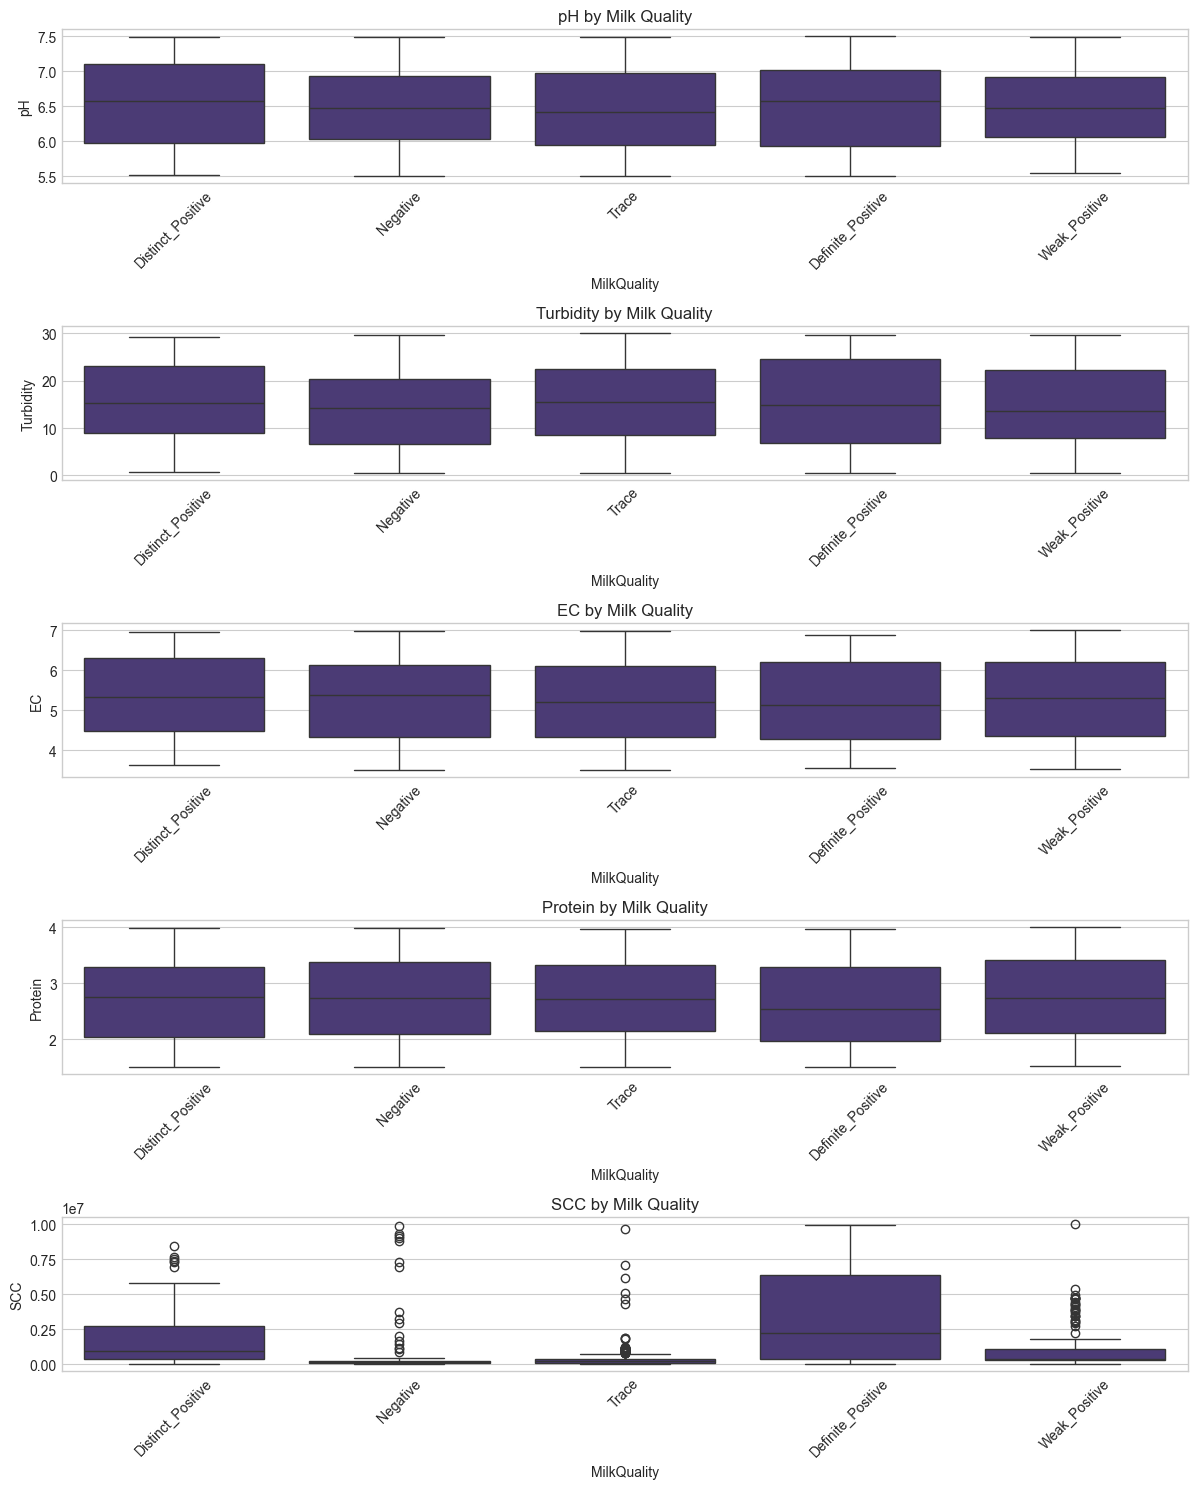

In [23]:
# Create boxplots to visualize feature distributions by quality category
features = ['pH', 'Turbidity', 'EC', 'Protein', 'SCC']

fig, axes = plt.subplots(len(features), 1, figsize=(12, 15))
for i, feature in enumerate(features):
    sns.boxplot(x='MilkQuality', y=feature, data=df_sample, ax=axes[i])
    axes[i].set_title(f'{feature} by Milk Quality', fontsize=12)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

Prepare the data for model training.

In [24]:
# Extract features and target
X = df[['pH', 'Turbidity', 'EC', 'Protein', 'SCC']]
y = df['MilkQuality']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Label Encoding Mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label} -> {i}")

Label Encoding Mapping:
Definite_Positive -> 0
Distinct_Positive -> 1
Negative -> 2
Trace -> 3
Weak_Positive -> 4


## 4. Train/Test Split (80/20)

Split the data for training and evaluation.

In [25]:
# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_scaled):.1%})")
print(f"Testing set size: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_scaled):.1%})")

Training set size: 40000 samples (80.0%)
Testing set size: 10000 samples (20.0%)


## 5. Model Training and Evaluation

Train and evaluate multiple machine learning models.

In [26]:
# Define models to evaluate
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42)
}

results = {}
best_accuracy = 0
best_model = None
best_model_name = None

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = name

print(f"\nBest Model: {best_model_name} (Accuracy: {best_accuracy:.4f})")


Training Random Forest...
Random Forest Accuracy: 0.4411
                   precision    recall  f1-score   support

Definite_Positive       0.47      0.36      0.40       930
Distinct_Positive       0.31      0.24      0.27      1204
         Negative       0.56      0.74      0.64      3395
            Trace       0.35      0.28      0.31      2647
    Weak_Positive       0.31      0.28      0.29      1824

         accuracy                           0.44     10000
        macro avg       0.40      0.38      0.38     10000
     weighted avg       0.42      0.44      0.42     10000


Training Gradient Boosting...
Gradient Boosting Accuracy: 0.4647
                   precision    recall  f1-score   support

Definite_Positive       0.55      0.33      0.41       930
Distinct_Positive       0.35      0.29      0.32      1204
         Negative       0.60      0.72      0.65      3395
            Trace       0.36      0.39      0.37      2647
    Weak_Positive       0.34      0.29      0.

## 6. Model Analysis

Analyze the best performing model.

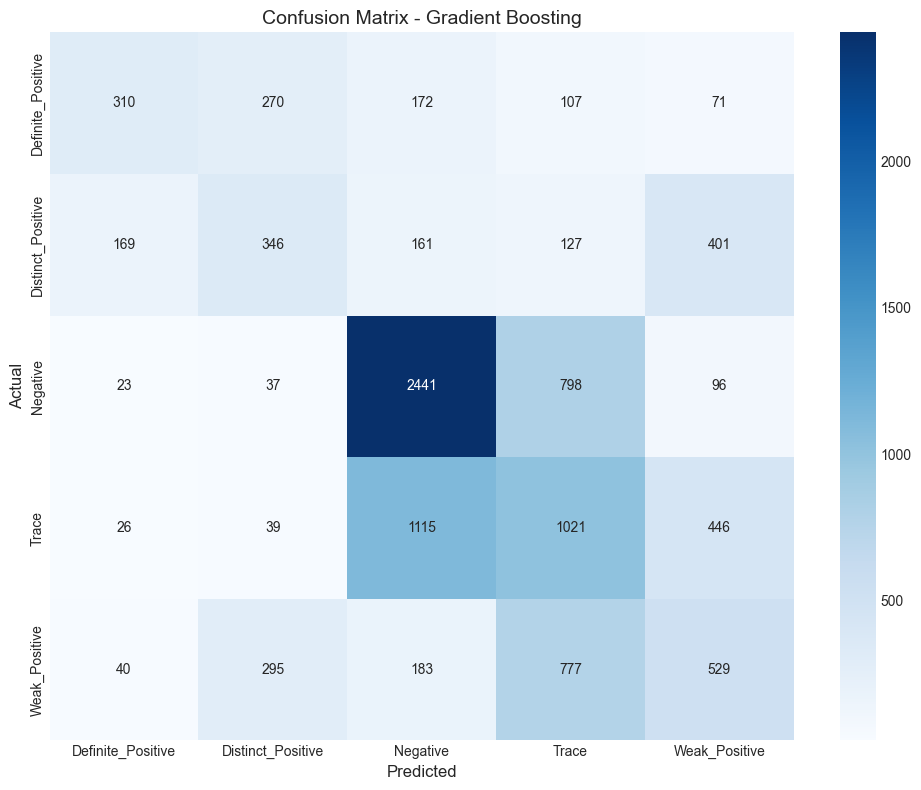

In [27]:
# Generate confusion matrix for the best model
y_pred_best = best_model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', 
            xticklabels=list(label_encoder.classes_), 
            yticklabels=list(label_encoder.classes_), 
            cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

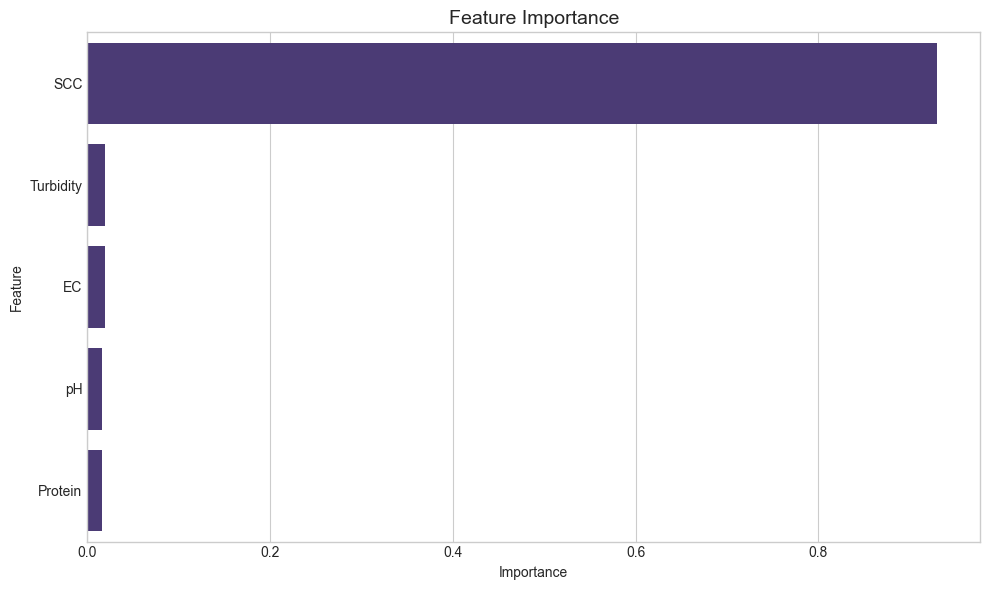

Feature Importance:
SCC: 0.9304
Turbidity: 0.0191
EC: 0.0189
pH: 0.0160
Protein: 0.0156


In [28]:
# Feature importance analysis (if available)
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    features = ['pH', 'Turbidity', 'EC', 'Protein', 'SCC']
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("Feature Importance:")
    for index, row in importance_df.iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")
else:
    print(f"The {best_model_name} model does not provide feature importance information.")

## 7. Model Comparison

Compare the performance of all models.

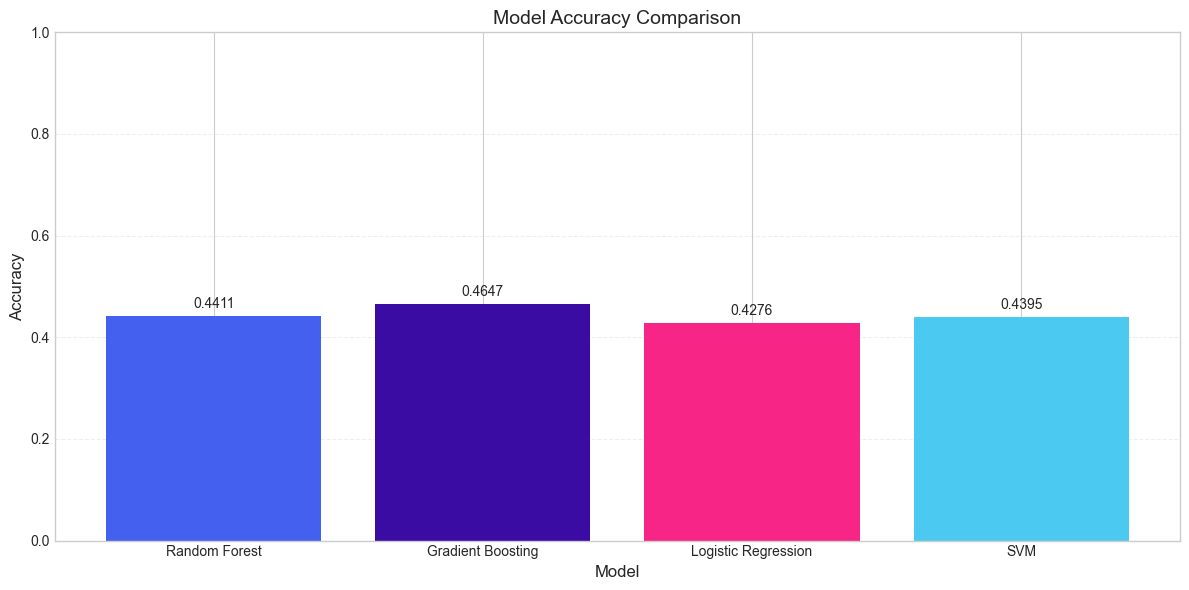

In [29]:
# Plot model accuracy comparison
plt.figure(figsize=(12, 6))
model_names = list(results.keys())
accuracies = list(results.values())

bars = plt.bar(model_names, accuracies, color=['#4361ee', '#3a0ca3', '#f72585', '#4cc9f0'])
plt.title('Model Accuracy Comparison', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.0)  # Full scale to show realistic accuracy

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Random Forest CV Accuracy: 0.4422 ± 0.0043
Gradient Boosting CV Accuracy: 0.4675 ± 0.0039
Logistic Regression CV Accuracy: 0.4255 ± 0.0021
SVM CV Accuracy: 0.4382 ± 0.0007


/var/folders/7r/bclj42dj1v7bjzt9nsm3m4yw0000gn/T/ipykernel_57580/483360761.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([cv_results[name] for name in model_names], labels=model_names)


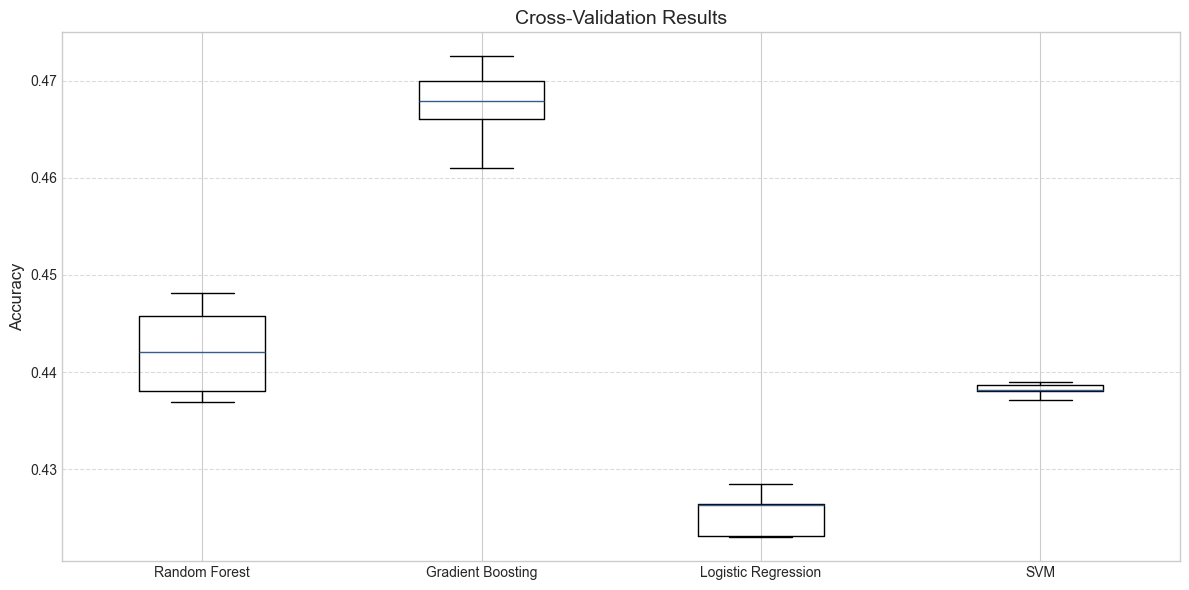

In [30]:
# Cross-validation results
cv_results = {}

for name, model in models.items():
    cv_scores = cross_val_score(model, X_scaled, y_encoded, cv=5)
    cv_results[name] = cv_scores
    print(f"{name} CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

plt.figure(figsize=(12, 6))
plt.boxplot([cv_results[name] for name in model_names], labels=model_names)
plt.title('Cross-Validation Results', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 8. Model Saving

Save the best model for future use.

In [31]:
# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

joblib.dump(best_model, 'models/milk_quality_model.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(label_encoder, 'models/label_encoder.pkl')

print(f"Best model ({best_model_name}) and preprocessing components saved successfully.")

Best model (Gradient Boosting) and preprocessing components saved successfully.


## 9. Prediction Examples

Demonstrate how to use the model for predictions.

In [32]:
# Example milk readings
example_readings = [
    {'ph': 6.8, 'turbidity': 2.5, 'ec': 4.5, 'protein': 3.2, 'scc': 150000},  # Should be Negative/Healthy
    {'ph': 6.3, 'turbidity': 6.0, 'ec': 5.2, 'protein': 2.9, 'scc': 350000},  # Should be Trace/Monitor
    {'ph': 5.8, 'turbidity': 15.0, 'ec': 6.5, 'protein': 2.2, 'scc': 3000000}  # Should be Distinct_Positive/Problematic
]

action_mapping = {
    'Negative': 'Safe to use',
    'Trace': 'Monitor',
    'Weak_Positive': 'Check the cow',
    'Distinct_Positive': 'Veterinary care',
    'Definite_Positive': 'Reject the milk'
}

print("Prediction Examples:")
print("-" * 80)

for i, reading in enumerate(example_readings):
    input_data = np.array([[reading['ph'], reading['turbidity'], reading['ec'], 
                           reading['protein'], reading['scc']]])
    
    input_data_scaled = scaler.transform(input_data)
    
    prediction = best_model.predict(input_data_scaled)[0]
    quality_category = label_encoder.inverse_transform([prediction])[0]
    
    action = action_mapping.get(quality_category, 'Unknown')
    
    print(f"Example {i+1}:")
    print(f"Input: {reading}")
    print(f"Predicted Quality: {quality_category}")
    print(f"Recommended Action: {action}")
    print("-" * 80)

Prediction Examples:
--------------------------------------------------------------------------------
Example 1:
Input: {'ph': 6.8, 'turbidity': 2.5, 'ec': 4.5, 'protein': 3.2, 'scc': 150000}
Predicted Quality: Negative
Recommended Action: Safe to use
--------------------------------------------------------------------------------
Example 2:
Input: {'ph': 6.3, 'turbidity': 6.0, 'ec': 5.2, 'protein': 2.9, 'scc': 350000}
Predicted Quality: Trace
Recommended Action: Monitor
--------------------------------------------------------------------------------
Example 3:
Input: {'ph': 5.8, 'turbidity': 15.0, 'ec': 6.5, 'protein': 2.2, 'scc': 3000000}
Predicted Quality: Distinct_Positive
Recommended Action: Veterinary care
--------------------------------------------------------------------------------


/Users/pnishimwe/Downloads/milk-quality/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/pnishimwe/Downloads/milk-quality/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/pnishimwe/Downloads/milk-quality/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
